# Plot effects of dicodon inserts on mRNA levels

## Load libraries and define analysis-specific parameters

In [ ]:
library(Biostrings)
library(tidyverse)
library(rasilabRtemplates)

insert_reads_cutoff <- 200 # The insert should get at least 200 reads across gRNA or mRNA
n_barcodes_cutoff <- 6 # The insert should have at least 6 barcodes across gRNA and mRNA after above cutoff

# Color-blind friendly palette. See http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

## Read back barcode counts 

This is calculated in [plot_alignment_statistics.ipynb](plot_alignment_statistics.md).

In [10]:

barcode_counts <- read_tsv("../tables/sample_insert_barcode_counts.tsv.gz") %>% 
  select(-sample_id, -linkage_count, - linkage_ref, -sample_name) %>%
  dplyr::rename(sample_name = library_type) %>% 
  print()

Rows: 270433 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): sample_id, sample_name, library_type, linkage_ref
dbl (4): insert_num, barcode_num, barcode_count, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 270,433 × 4
   insert_num barcode_num barcode_count sample_name
        <dbl>       <dbl>         <dbl> <chr>      
 1       3842        1303         43068 grna       
 2       3267      434926         17363 grna       
 3       3499       15655         14231 grna       
 4       5285      284711         14113 grna       
 5        783      434898         14103 grna       
 6       4915      430480         13708 grna       
 7       5436      434972         12663 grna       
 8        697       21478         12214 grna       
 9       2978      375595         11769 grna       
10       2609        7605         11508 grna       
# … with 270,423 more rows



## Read insert annotations 

In [11]:

insert_annotations <- read_tsv("../../pool1_linkage/annotations/insert_annotations/dicodon_linkage.tsv") %>% 
  select(insert_num, insert) %>%
  arrange(insert_num) %>%
  dplyr::slice(1:4096) %>% 
  print()

Rows: 6000 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): group, insert, seq
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 4,096 × 2
   insert_num insert                                          
        <dbl> <chr>                                           
 1          0 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
 2          1 AAAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAAC
 3          2 AAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAG
 4          3 AAAAATAAAAATAAAAATAAAAATAAAAATAAAAATAAAAATAAAAAT
 5          4 AAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAACA
 6          5 AAAACCAAAACCAAAACCAAAACCAAAACCAAAACCAAAACCAAAACC
 7          6 AAAACGAAAACGAAAACGAAAACGAAAACGAAAACGAAAACGAAAACG
 8          7 AAAACTAAAACTAAAACTAAAACTAAAACTAAAACTAAAACTAAAACT
 9          8 AAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAGA
10          9 AAAAGCAAAAGCAAAAGCAAAAGCAAAAGCAAAAGCAAAAGCAAAAGC
# … with 4,086 more rows


## Extract dipeptide annotations


In [12]:

insert_annotations <- insert_annotations %>%
  mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>% 
  mutate(diaa = as.character(translate(DNAStringSet(dicodon), no.init.codon = T))) %>%
  mutate(codon1 = substr(dicodon, 1, 3), codon2 = substr(dicodon, 4, 6),
         aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
  select(-insert) %>%
  print()

# A tibble: 4,096 × 7
   insert_num dicodon diaa  codon1 codon2 aa1   aa2  
        <dbl> <chr>   <chr> <chr>  <chr>  <chr> <chr>
 1          0 AAAAAA  KK    AAA    AAA    K     K    
 2          1 AAAAAC  KN    AAA    AAC    K     N    
 3          2 AAAAAG  KK    AAA    AAG    K     K    
 4          3 AAAAAT  KN    AAA    AAT    K     N    
 5          4 AAAACA  KT    AAA    ACA    K     T    
 6          5 AAAACC  KT    AAA    ACC    K     T    
 7          6 AAAACG  KT    AAA    ACG    K     T    
 8          7 AAAACT  KT    AAA    ACT    K     T    
 9          8 AAAAGA  KR    AAA    AGA    K     R    
10          9 AAAAGC  KS    AAA    AGC    K     S    
# … with 4,086 more rows


## Function for bootstrap mRNA levels

In [13]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$grna))
}


## What is the average effect of each amino acid in the first and second dicodon position?

# A tibble: 166,429 × 4
   insert_num barcode_num  grna  mrna
        <dbl>       <dbl> <dbl> <dbl>
 1       3842        1303 43068  1116
 2       3267      434926 17363    23
 3       3499       15655 14231   417
 4       5285      284711 14113   454
 5        783      434898 14103    17
 6       4915      430480 13708  2475
 7       5436      434972 12663  4053
 8        697       21478 12214    21
 9       2978      375595 11769     8
10       2609        7605 11508    17
# … with 166,419 more rows
# A tibble: 72,306 × 10
   insert_num barcode_num  grna  mrna dicodon diaa  codon1 codon2 aa1   aa2  
        <dbl>       <dbl> <dbl> <dbl> <chr>   <chr> <chr>  <chr>  <chr> <chr>
 1       3842        1303 43068  1116 TTAAAG  LK    TTA    AAG    L     K    
 2       3267      434926 17363    23 TATAAT  YN    TAT    AAT    Y     N    
 3       3499       15655 14231   417 TCGGGT  SG    TCG    GGT    S     G    
 4        783      434898 14103    17 ATAATT  II    ATA    ATT    I     I    
 

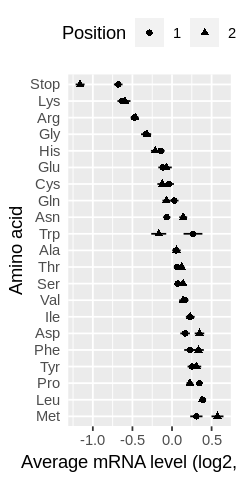

In [14]:
options(repr.plot.width=2, repr.plot.height=4) # For ipynb visualization

aa1_lfc <- barcode_counts %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% print %>%  
  drop_na() %>% 
  inner_join(insert_annotations, by = "insert_num") %>% print  %>%
  group_by(aa1) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(pos = 1) %>%
  rename(aa = aa1) %>%
  print()

aa2_lfc <- barcode_counts %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  group_by(aa2) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(pos = 2) %>%
  rename(aa = aa2) %>%
  print()

AMINO_ACID_CODE = c(AMINO_ACID_CODE, c("*" = "Stop"))

plot_data <- bind_rows(aa1_lfc, aa2_lfc) %>%
  group_by(aa) %>% 
  mutate(order = mean(lfc)) %>% 
  ungroup() %>% 
  mutate(aa = fct_reorder(AMINO_ACID_CODE[aa], -order)) %>% 
  select(-order)

plot_data %>%
  ggplot(aes(x = lfc, y = aa, shape = as.factor(pos),
             xmin = lfc - lfc_sd, xmax = lfc + lfc_sd,
             )) +
  geom_errorbar(width=0, color = 'black') +
  geom_point() +
  theme(legend.position = "top",
        axis.line = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid.major.y = element_line(),
        axis.title.x = element_text(margin = margin(t = 4))
        ) +
  labs(x = "Average mRNA level (log2, a.u.)", y = "Amino acid",
       shape = "Position")

ggsave("../figures/average_amino_acid_effect.pdf", width= 1.2, height= 3)

## Calculate mRNA levels of dipeptides

Filter for inserts with at least 6 barcodes total and 200 reads total

Log fold change is log2(mRNA/gRNA) and is median-normalized across the full library.

In [ ]:
diaa_lfc <- barcode_counts %>% 
  group_by(insert_num, sample_name) %>%
  summarize(count = sum(barcode_count), n_barcodes = dplyr::n()) %>%
  ungroup() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  filter(sample_name != 'gdna') %>% 
  group_by(diaa, aa1, aa2, sample_name) %>%
  mutate(count = sum(count), n_barcodes = sum(n_barcodes)) %>%
  ungroup() %>%
  group_by(diaa, aa1, aa2) %>%
  filter(sum(count) >= insert_reads_cutoff, sum(n_barcodes) >= n_barcodes_cutoff) %>%
  ungroup() %>% 
  pivot_wider(names_from = sample_name, values_from = c("count", "n_barcodes")) %>%
  mutate(lfc = log2(count_mrna) - log2(count_grna)) %>% 
  group_by(diaa, aa1, aa2) %>% print  %>%
  slice(1) %>% 
  ungroup() %>% 
  mutate(lfc = lfc - median(lfc)) %>%
  arrange(lfc) %>%
  write_tsv("../tables/8xdipeptide_lfc.tsv.gz") %>%
  print()

`summarise()` has grouped output by 'insert_num'. You can override using the `.groups` argument.


# A tibble: 4,012 × 12
# Groups:   diaa, aa1, aa2 [441]
   insert_num dicodon diaa  codon1 codon2 aa1   aa2   count_grna count_mrna
        <dbl> <chr>   <chr> <chr>  <chr>  <chr> <chr>      <dbl>      <dbl>
 1          0 AAAAAA  KK    AAA    AAA    K     K          92534     129148
 2          1 AAAAAC  KN    AAA    AAC    K     N         100503      72712
 3          2 AAAAAG  KK    AAA    AAG    K     K          92534     129148
 4          3 AAAAAT  KN    AAA    AAT    K     N         100503      72712
 5          4 AAAACA  KT    AAA    ACA    K     T         186174     109825
 6          5 AAAACC  KT    AAA    ACC    K     T         186174     109825
 7          6 AAAACG  KT    AAA    ACG    K     T         186174     109825
 8          7 AAAACT  KT    AAA    ACT    K     T         186174     109825
 9          8 AAAAGA  KR    AAA    AGA    K     R         296126     204498
10          9 AAAAGC  KS    AAA    AGC    K     S         295021     220213
# … with 4,002 more rows, and 3 

## Effect of dipeptide on mRNA level as a heat map

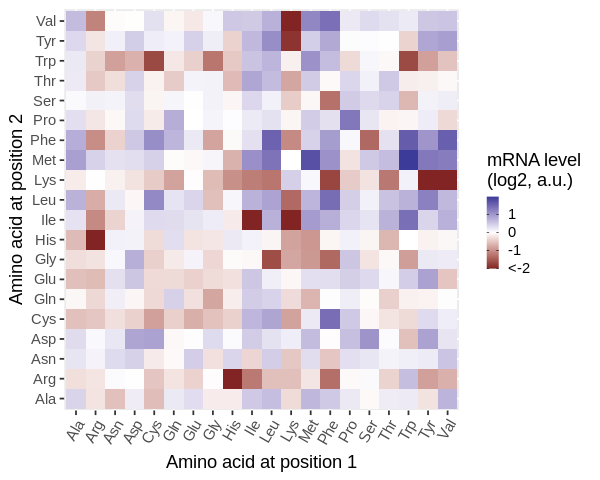

In [ ]:
options(repr.plot.width=5, repr.plot.height=4) # For ipynb visualization

AMINO_ACID_CODE = c(AMINO_ACID_CODE, c("*" = "Stop"))

diaa_lfc %>% 
  mutate(aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
  complete(aa1, aa2) %>% 
  filter(aa1 != "*", aa2 != "*") %>% 
  mutate(lfc = case_when(
    lfc < -2 ~ -2,
    lfc > 2  ~ 2,
    T ~ lfc)) %>%
  mutate(aa1 = AMINO_ACID_CODE[aa1], aa2 = AMINO_ACID_CODE[aa2]) %>% 
  # mutate(aa2 = fct_rev(aa2)) %>%
  # mutate(aa1 = fct_relevel(aa1, "Stop", after = 20)) %>% 
  # mutate(aa2 = fct_relevel(aa2, "Stop", after = 20)) %>% 
  ggplot(aes(x = aa1, y = aa2, fill = lfc)) +
  geom_tile() +
  scale_fill_gradient2(labels = c("<-2", -1, 0, 1, ">2"),
                       guide = guide_colorbar(barwidth = 0.5, barheight = 3, ticks.colour = "black"), na.value = "grey50") +
  # scale_fill_viridis_c() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1),
        axis.title.x = element_text(margin = margin(t = 4)),
        axis.line = element_blank()
        ) +
  labs(fill = "mRNA level\n(log2, a.u.)", x = "Amino acid at position 1", y = "Amino acid at position 2")
  # print()

ggsave("../figures/dipeptide_mrna_heatmap.pdf", width = 5, height = 4)

## Calculate mRNA levels of dicodons

Filter for inserts with at least 6 barcodes total and 200 reads total

Log fold change is log2(mRNA/gRNA) and is median-normalized across the full library.

In [17]:

dicodon_lfc <- barcode_counts %>% 
  group_by(insert_num, sample_name) %>%
  summarize(count = sum(barcode_count), n_barcodes = dplyr::n()) %>%
  ungroup() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  group_by(dicodon, diaa, aa1, aa2, sample_name) %>%
  summarize(count = sum(count), n_barcodes = sum(n_barcodes)) %>%
  ungroup() %>%
  pivot_wider(names_from = sample_name, values_from = c("count", "n_barcodes")) %>%
  filter(count_grna + count_mrna >= insert_reads_cutoff) %>%
  filter(n_barcodes_grna + n_barcodes_mrna >= n_barcodes_cutoff) %>%
  mutate(lfc = log2(count_mrna) - log2(count_grna)) %>%
  mutate(lfc = lfc - median(lfc)) %>%
  arrange(lfc) %>%
  print()

`summarise()` has grouped output by 'insert_num'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'dicodon', 'diaa', 'aa1', 'aa2'. You can override using the `.groups` argument.


# A tibble: 3,944 × 9
   dicodon diaa  aa1   aa2   count_grna count_mrna n_barcodes_grna
   <chr>   <chr> <chr> <chr>      <dbl>      <dbl>           <int>
 1 CGCCAT  RH    R     H          13474         12              15
 2 ATCATA  II    I     I           2991          3               4
 3 GTAAAG  VK    V     K           6590          8               8
 4 ATAATC  II    I     I           5618          7               8
 5 GTCAAG  VK    V     K           3340          5               8
 6 GGCTGA  G*    G     *          10444         16              12
 7 CTGGGA  LG    L     G           2802          5               4
 8 CGATAA  R*    R     *           8663         16              14
 9 AAGTGA  K*    K     *          11308         21              16
10 GGCTAA  G*    G     *           6798         13               6
# … with 3,934 more rows, and 2 more variables: n_barcodes_mrna <int>,
#   lfc <dbl>


# Identify dipeptides in all 6 reading frames

In [18]:

diaa_allframe_lfc <- dicodon_lfc %>% 
  crossing(frame = c("frame" = seq(0,5))) %>%
  select(-lfc, -diaa, -aa1, -aa2) %>%
  mutate(dicodon = substr(paste0(dicodon, dicodon), frame + 1, 6 + frame)) %>%
  mutate(diaa = as.character(translate(DNAStringSet(dicodon), no.init.codon = T))) %>%
  select(-dicodon) %>%
  group_by(diaa, frame) %>%
  summarize_all(sum) %>%
  ungroup() %>%
  filter(count_grna + count_mrna >= insert_reads_cutoff) %>%
  mutate(lfc = log2(count_mrna / count_grna)) %>%
  select(diaa, frame, lfc) %>%
  print()

# A tibble: 2,640 × 3
   diaa  frame    lfc
   <chr> <int>  <dbl>
 1 **        0 -0.292
 2 **        1  0.415
 3 **        2  0.303
 4 **        3 -0.292
 5 **        4  0.415
 6 **        5  0.303
 7 *A        0 -1.19 
 8 *A        1 -0.717
 9 *A        2 -0.613
10 *A        3 -1.91 
# … with 2,630 more rows


# Compare the effect of dipeptides in different reading frames

Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(fit, n))`, with `mutate()` if needed”


frame,n,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<chr>,<int>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>
+1,189,r=0.29,4.145293,5.140329e-05,187,0.15373330,0.4156194,Pearson's product-moment correlation,two.sided
+2,189,r=0.18,2.460306,1.478978e-02,187,0.03523254,0.3119193,Pearson's product-moment correlation,two.sided
+3,189,r=0.8,18.183542,3.288357e-43,187,0.74101479,0.8454982,Pearson's product-moment correlation,two.sided


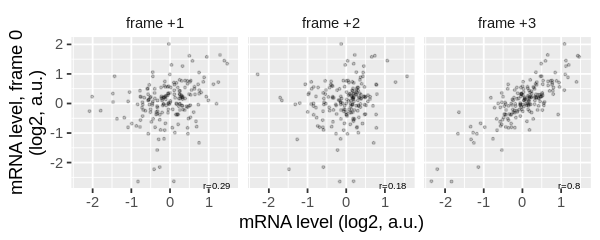

In [19]:
options(repr.plot.width=5, repr.plot.height=2) # For ipynb visualization

plot_data <- diaa_allframe_lfc %>% 
  filter(!diaa %in% c("GW", "WG")) %>% 
  group_by(diaa) %>% 
  mutate(frame0_lfc = lfc[frame == 0]) %>% 
  ungroup() %>% 
  filter(frame %in% c(1,2,3)) %>% 
  mutate(frame = paste0("+", frame)) %>% 
  filter(!str_detect(diaa, "\\*")) %>% 
  mutate(aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>% 
  filter(aa1 > aa2)

label_data <- plot_data %>% 
  group_by(frame) %>% 
  nest() %>% 
  mutate(n = map_int(data, nrow), fit = map(data, function(df) cor.test(~frame0_lfc + lfc, data = df))) %>% 
  mutate(fit = map(fit, broom::tidy)) %>% 
  unnest(fit, n) %>% 
  select(-data) %>%
  mutate(estimate = paste0("r=", round(estimate, 2)))

plot_data %>% 
  ggplot(aes(x = lfc, y = frame0_lfc)) +
  facet_wrap(~ frame, ncol = 5, labeller = as_labeller(. %>% paste("frame", .))) +
  geom_point(size = 0.5, alpha = 0.2) +
  geom_text(aes(label = estimate), x = 1.2, y = -2.8, data = label_data, size=2) +
  theme(strip.background = element_blank()) +
  labs(x = "mRNA level (log2, a.u.)", y = "mRNA level, frame 0\n(log2, a.u.)")

ggsave("../figures/dipeptide_frame_effect.pdf", width = 3, height = 1.2)

label_data

## Plot synonymous codon effects for highly destabilizing inserts 

```{r, fig.width=2, fig.height=1.2}

# A tibble: 3,575 × 10
   dicodon diaa  aa1   aa2   count_grna count_mrna n_barcodes_grna
   <chr>   <chr> <chr> <chr>      <dbl>      <dbl>           <int>
 1 CGCCAT  RH    R     H          13474         12              15
 2 ATCATA  II    I     I           2991          3               4
 3 GTAAAG  VK    V     K           6590          8               8
 4 ATAATC  II    I     I           5618          7               8
 5 GTCAAG  VK    V     K           3340          5               8
 6 CTGGGA  LG    L     G           2802          5               4
 7 GTCAAA  VK    V     K          16040         60              17
 8 AAAGTA  KV    K     V          19265        535              24
 9 TTAGGC  LG    L     G          15000        618              15
10 CATCGG  HR    H     R           9643        485              10
# … with 3,565 more rows, and 3 more variables: n_barcodes_mrna <int>,
#   lfc <dbl>, group <chr>


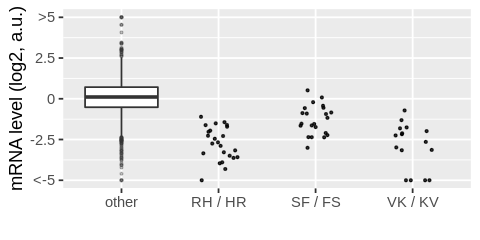

In [21]:
options(repr.plot.width=4, repr.plot.height=2) # For ipynb visualization

plot_data <- dicodon_lfc %>% 
  filter(!str_detect(diaa, "\\*")) %>% 
  mutate(group = case_when(
    diaa %in% c("RH", "HR") ~ "RH / HR",
    diaa %in% c("VK", "KV") ~ "VK / KV",
    diaa %in% c("SF", "FS") ~ "SF / FS",
    T ~ "other"
  )) %>% 
  mutate(lfc = case_when(
    lfc > 5 ~ 5,
    lfc < -5 ~ -5,
    T ~ lfc)) %>% 
  print()

plot_data %>% 
  ggplot(aes(x = group, y = lfc)) +
  geom_jitter(height = 0, width=0.2, size = 0.5, alpha = 0.8, data = plot_data %>% filter(!group == "other")) +
  geom_boxplot(data = plot_data %>% filter(group == "other"), outlier.size = 0.5, outlier.alpha = 0.3) +
  labs(x = "", y = "mRNA level (log2, a.u.)") +
  scale_y_continuous(breaks = c(-5, -2.5, 0, 2.5, 5), labels = c("<-5", -2.5, 0, 2.5, ">5"))

ggsave("../figures/synonmous_codon_effects.pdf", width = 2, height = 1.2)

## Load codon effect values from the literature

In [ ]:
library(data.table)
codon_params <- fread("../tables/narula_wu_forrest_codon_effects.tsv") %>% 
  setkey(codon) %>% 
  print()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


The following object is masked from ‘package:IRanges’:

    shift


The following objects are masked from ‘package:S4Vectors’:

    first, second




    codon aa_name aa gc_content gc3_content narula2019_293t_orfeome
 1:   AAA     Lys  K       0.00           0           -0.1784360795
 2:   AAC     Asn  N       0.33           1            0.0662645810
 3:   AAG     Lys  K       0.33           1           -0.1061097740
 4:   AAT     Asn  N       0.00           0           -0.0959877475
 5:   ACA     Thr  T       0.33           0           -0.0495674438
 6:   ACC     Thr  T       0.66           1            0.1251921132
 7:   ACG     Thr  T       0.66           1            0.0173439673
 8:   ACT     Thr  T       0.33           0           -0.0189809530
 9:   AGA     Arg  R       0.33           0           -0.1213917820
10:   AGC     Ser  S       0.66           1            0.0230869407
11:   AGG     Arg  R       0.66           1           -0.1182617107
12:   AGT     Ser  S       0.33           0           -0.1339170923
13:   ATA     Ile  I       0.00           0           -0.0988975015
14:   ATC     Ile  I       0.33           1     

## Calculate average codon effects

In [ ]:
codon1_lfc <- barcode_counts %>% 
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>% 
  inner_join(insert_annotations, by = "insert_num") %>% 
  group_by(codon1) %>% 
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(pos = 1) %>%
  dplyr::rename(codon = codon1) %>% print()

codon2_lfc <- barcode_counts %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  group_by(codon2) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(pos = 2) %>%
  dplyr::rename(codon = codon2) # %>% print()

codon_data <- bind_rows(codon1_lfc, codon2_lfc) %>%
  group_by(codon) %>% 
  mutate(order = mean(lfc)) %>% 
  ungroup() %>% 
  mutate(codon = fct_reorder(codon, -order)) %>% 
 # arrange(order) %>% print 
  select(-order) # %>% print 

combined_codon_data <- codon_data %>% 
  left_join(codon_params, by = "codon") %>% print

# A tibble: 64 × 4
   codon     lfc lfc_sd   pos
   <chr>   <dbl>  <dbl> <dbl>
 1 TTA    0.151  0.102      1
 2 TAT    0.246  0.0816     1
 3 TCG   -0.0886 0.0902     1
 4 ATA    0.0486 0.0795     1
 5 AGG   -0.957  0.104      1
 6 GTG    0.0391 0.103      1
 7 GGA   -0.491  0.114      1
 8 GTA    0.129  0.0988     1
 9 TAA   -0.733  0.0835     1
10 GTT    0.261  0.0931     1
# … with 54 more rows
# A tibble: 128 × 15
   codon     lfc lfc_sd   pos aa_name aa    gc_content gc3_content
   <chr>   <dbl>  <dbl> <dbl> <chr>   <chr>      <dbl>       <int>
 1 TTA    0.151  0.102      1 Leu     L           0              0
 2 TAT    0.246  0.0816     1 Tyr     Y           0              0
 3 TCG   -0.0886 0.0902     1 Ser     S           0.66           1
 4 ATA    0.0486 0.0795     1 Ile     I           0              0
 5 AGG   -0.957  0.104      1 Arg     R           0.66           1
 6 GTG    0.0391 0.103      1 Val     V           0.66           1
 7 GGA   -0.491  0.114      1 Gly     G   


## Plot 1st and 2nd codon position values 

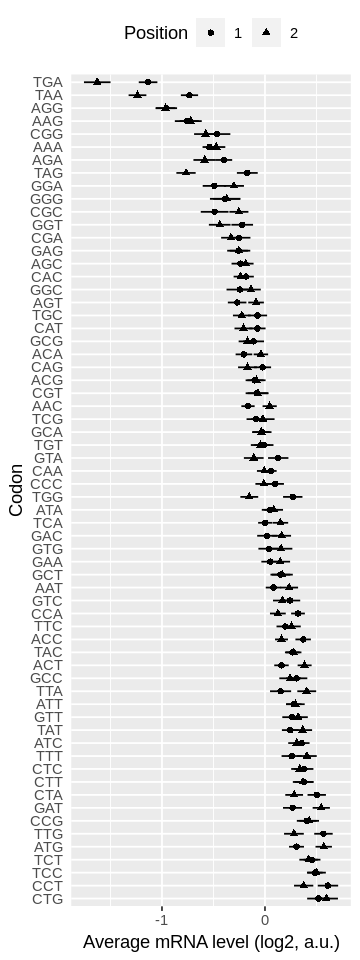

In [ ]:
options(repr.plot.width=3, repr.plot.height=8)

codon_data %>%
  ggplot(aes(x = lfc, y = codon, shape = as.factor(pos),
             xmin = lfc - lfc_sd, xmax = lfc + lfc_sd,
             )) +
  geom_errorbar(width=0, color = 'black') +
  geom_point() +
  theme(legend.position = "top",
        axis.line = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid.major.y = element_line(),
        axis.title.x = element_text(margin = margin(t = 4))
        ) +
  labs(x = "Average mRNA level (log2, a.u.)", y = "Codon",
       shape = "Position")



## Calculate mean codon effect across both positions (eg. all contexts)

In [ ]:
mean_codon <- codon_data %>% 
  group_by(codon) %>% 
  # average codon effects across position
  mutate(mean_lfc = mean(lfc)) %>%
  ungroup() %>% 
  select(codon, mean_lfc) %>% 
  # remove duplicates
  distinct() %>%
  # Arrange alphabetically
  arrange(codon) %>% 
  # Convert T to U, for RNA. Want this for plotting codon chart below 
  mutate(codon = str_replace_all(codon,"T", "U")) 

mean_codon_params <- mean_codon %>%
  # back convert U to T, to join codons parameter data for plotting
  mutate(codon = str_replace_all(codon,"U", "T")) %>% 
  left_join(codon_params, by = "codon") %>% 
  # Remove stop codons, for plotting without NAs
  filter(!str_detect(codon, "TAG|TAA|TGA")) %>% print 

# A tibble: 61 × 13
   codon mean_lfc aa_name aa    gc_content gc3_content narula2019_293t_orfeome
   <chr>    <dbl> <chr>   <chr>      <dbl>       <int>                   <dbl>
 1 CTG      0.558 Leu     L           0.66           1                  0.171 
 2 CCT      0.494 Pro     P           0.66           0                 -0.0259
 3 TCC      0.492 Ser     S           0.66           1                  0.0927
 4 TCT      0.440 Ser     S           0.33           0                 -0.0868
 5 ATG      0.438 Met     M           0.33           1                  0.0392
 6 TTG      0.424 Leu     L           0.33           1                 -0.0810
 7 CCG      0.417 Pro     P           1              1                 -0.0308
 8 GAT      0.407 Asp     D           0.33           0                 -0.122 
 9 CTA      0.393 Leu     L           0.66           0                 -0.0774
10 CTT      0.375 Leu     L           0.33           0                 -0.0225
# … with 51 more rows, and 6 mor

[1] 0.24251264 0.05968451


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



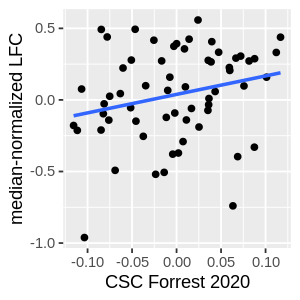

In [ ]:
options(repr.plot.width=2.5, repr.plot.height=2.5)

# Calculate pearson correlation
pearson_r = cor(mean_codon_params$forrest2020_hela_csc, mean_codon_params$mean_lfc, method=c('pearson'))
p = cor.test(mean_codon_params$forrest2020_hela_csc, mean_codon_params$mean_lfc, method=c('pearson'))$p.value

# Print r correlation and p value. # I will manually add these values to the figures.
print(c(pearson_r, p)) 

# Plot codon effects plus pearson correlation
mean_codon_params %>%
    mutate(name = str_c(codon, " (", GENETIC_CODE[codon], ")")) %>% 
    ggplot() +
    aes(x = forrest2020_hela_csc, y = mean_lfc) +
    geom_point() + 
    geom_smooth(method=lm, se=FALSE) +
    labs(y='median-normalized LFC', x='CSC Forrest 2020')
    

ggsave("../figures/compare_to_forrest_csc.pdf", width = 2, height = 2)



## Scatter plot comparison of 8x mean Amino Acid effects to Forrest2020

- No significant correlation at the amino acid level when all residues are considered.  

- However, remove R|K|G amino acids results in a significant and fairly strong correlation. 

```{r, fig.height=2, fig.width=2}


[1] 0.53493945 0.02692654


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



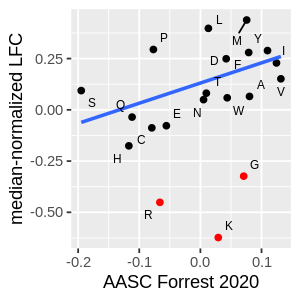

In [ ]:
options(repr.plot.width=2.5, repr.plot.height=2.5)

# Calculate average amino acid effects 
aa_params <- mean_codon_params %>%
  select(mean_lfc, aa, forest2020_hela_aasc) %>% 
  group_by(aa) %>% 
  mutate(aa_lfc = mean(mean_lfc)) %>% 
  ungroup() %>% 
  select(-mean_lfc) %>% 
  distinct() 

# Pull R|K|G motifs out to plot separetly, without geom_smooth or pearson's 
plot_rkg <- aa_params %>% 
  filter(str_detect(aa, "R|K|G")) 
# Remove R|K|G from main plotting data
mean_aa_params <- aa_params %>% 
  filter(!str_detect(aa, "R|K|G"))

# Calculate pearson correlation (for data without R|K|G amino acids)
pearson_r = cor(mean_aa_params$forest2020_hela_aasc, mean_aa_params$aa_lfc, method=c('pearson'))
p = cor.test(mean_aa_params$forest2020_hela_aasc, mean_aa_params$aa_lfc, method=c('pearson'))$p.value

# Print r correlation and p value. pearson_r = 0.54 , person_p = 0.0257
# I will manually add these values to the figures, rather than doing it in R (too difficult to make look nice)
print(c(pearson_r, p)) 


# Plot codon effects plus pearson correlation
mean_aa_params %>%
    mutate(name = aa) %>% 
    ggplot() +
    aes(x= forest2020_hela_aasc, y=aa_lfc) +
    geom_point() + 
    geom_smooth(method=lm, se=FALSE) +
#    geom_text(aes(label = str_c("pearson_r = ", round(pearson_r, 2))), x = -0.111, y = 0.57, size=3) +
#    geom_text(aes(label = str_c("pearson_p = ", round(p, 4))), x = -0.111, y = 0.5, size=3) +
    ggrepel::geom_text_repel(mapping=aes(x = forest2020_hela_aasc, y = aa_lfc, label=name), size = 2.5) +
    # Add R|K|G points back to the plot. Highlight color. Add text. 
    geom_point(data = plot_rkg, aes(), color = "red")+
    ggrepel::geom_text_repel(data = plot_rkg, mapping=aes(x = forest2020_hela_aasc, y = aa_lfc, label=aa), size = 2.5) +
    labs(x='AASC Forrest 2020', y='median-normalized LFC')+
    NULL

ggsave("../figures/compare_to_forrest_aasc.pdf", width = 2, height = 2)

## Plot 8x library codon effects with optimal/nonoptimal codon status

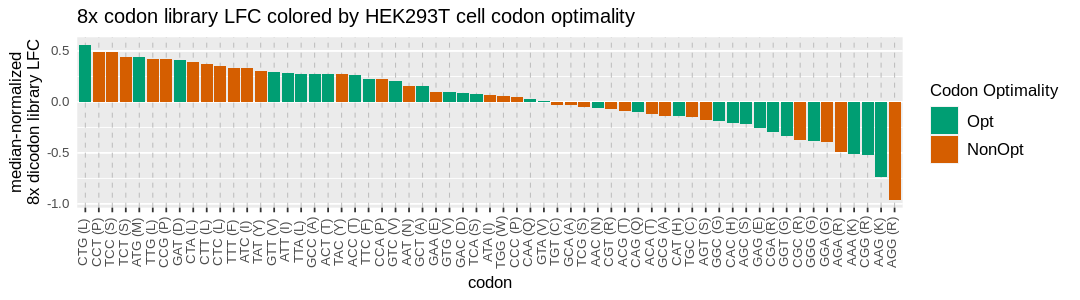

In [ ]:
options(repr.plot.width=9, repr.plot.height=2.5)

groupcolors = c(Opt = "#009E73", NonOpt = "#D55E00")

mean_codon_params %>%
    mutate(name = str_c(codon, " (", GENETIC_CODE[codon], ")")) %>% 
    mutate(facet = fct_reorder(name, -mean_lfc)) %>%  
    ggplot() +
    geom_bar(stat='identity') +
    aes(x = facet, y=mean_lfc, fill= `293t_optimality`) +
    theme(
          axis.line = element_blank(),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(margin = margin(t = 4)),
          axis.text.x = element_text(angle = 90, vjust=0.2),
          text = element_text(size = 10),
          legend.text=element_text(size=10),
          panel.grid.major.x = element_line(color = "grey",
                                            size = 0.3,
                                            linetype = 2)) +
  scale_fill_manual(values = groupcolors) +
  labs(x='codon', y='median-normalized\n8x dicodon library LFC', title='8x codon library LFC colored by HEK293T cell codon optimality', fill='Codon Optimality')

ggsave("../figures/plot_codons_by_293t_optimality.pdf", width = 9, height = 2.5)

## Load codon chart coordinate map

- Made manually by Phil - We'll see how well it works...

- Note that "text" refers to codon, amino acid, and nucleotide codes. This is because I want to plot all of these things with specified coordinates. 

- As such, also note that some AAs and nts have multiple coordinate sets, since they appear more than once on the map.   


In [ ]:

codon_coords <- read_tsv("../tables/hardcode_codon_chart.tsv") %>% 
  print()

Rows: 96 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): aa, text
dbl (2): x_coord, y_coord

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 96 × 4
   aa    text  x_coord y_coord
   <chr> <chr>   <dbl>   <dbl>
 1 Phe   UUU         2      16
 2 Phe   UUC         2      15
 3 Leu   UUA         2      14
 4 Leu   UUG         2      13
 5 Leu   CUU         2      12
 6 Leu   CUC         2      11
 7 Leu   CUA         2      10
 8 Leu   CUG         2       9
 9 Ile   AUU         2       8
10 Ile   AUC         2       7
# … with 86 more rows


## Join mean codon effects to codon heatmap coordinates

In [ ]:
codon_coord_data <- codon_coords %>% 
  dplyr::rename(codon = text) %>% 
  left_join(mean_codon, by = "codon") %>% 
  # Set max effects to -0.5 and 0.5, for a better scale-fill gradient.  
  mutate(mean_lfc = case_when(
    mean_lfc < -0.5 ~ -0.5,
    mean_lfc > 0.5  ~ 0.5,
    T ~ mean_lfc)) %>% print 

# A tibble: 96 × 5
   aa    codon x_coord y_coord mean_lfc
   <chr> <chr>   <dbl>   <dbl>    <dbl>
 1 Phe   UUU         2      16    0.333
 2 Phe   UUC         2      15    0.226
 3 Leu   UUA         2      14    0.278
 4 Leu   UUG         2      13    0.424
 5 Leu   CUU         2      12    0.375
 6 Leu   CUC         2      11    0.357
 7 Leu   CUA         2      10    0.393
 8 Leu   CUG         2       9    0.558
 9 Ile   AUU         2       8    0.288
10 Ile   AUC         2       7    0.332
# … with 86 more rows
# A tibble: 96 × 5
   aa    codon x_coord y_coord mean_lfc
   <chr> <chr>   <dbl>   <dbl>    <dbl>
 1 Phe   UUU         2      16    0.333
 2 Phe   UUC         2      15    0.226
 3 Leu   UUA         2      14    0.278
 4 Leu   UUG         2      13    0.424
 5 Leu   CUU         2      12    0.375
 6 Leu   CUC         2      11    0.357
 7 Leu   CUA         2      10    0.393
 8 Leu   CUG         2       9    0.5  
 9 Ile   AUU         2       8    0.288
10 Ile   AUC        


## Plot mean codon effects as a colored heatmap codon chart

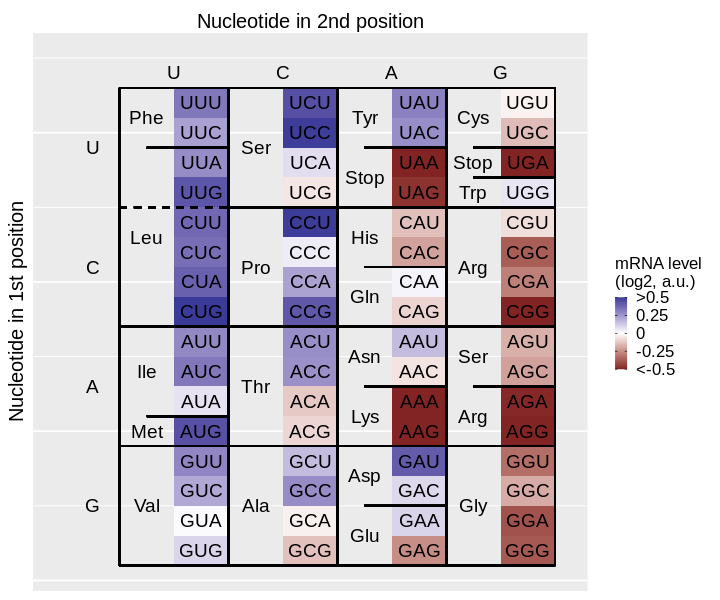

In [ ]:
options(repr.plot.width=6, repr.plot.height=5)

codon_coord_data %>%
  ggplot(aes(x = x_coord, y = y_coord, fill = mean_lfc)) +
  geom_tile(lwd = 1.5, linetype = 0, width = 1 , height = 1) +
  # Add heatmap gradient to tiles
  scale_fill_gradient2(labels = c("<-0.5", -0.25, 0, 0.25, ">0.5"),
                       guide = guide_colorbar(barwidth = 0.5, barheight = 3, ticks.colour = "black"), na.value = "0") +
  # Add text labels to each element
  geom_text(aes(label = codon), color = "black", size = 4) +
  # Define vertical line(s)
  geom_segment(x = 0.5, y = 0.5, xend = 0.5, yend = 16.5, size = 0.5)+
  geom_segment(x = 2.5, y = 0.5, xend = 2.5, yend = 16.5, size = 0.5)+
  geom_segment(x = 4.5, y = 0.5, xend = 4.5, yend = 16.5, size = 0.5)+
  geom_segment(x = 6.5, y = 0.5, xend = 6.5, yend = 16.5, size = 0.5)+
  geom_segment(x = 8.5, y = 0.5, xend = 8.5, yend = 16.5, size = 0.5)+
  # Define horizontal line(s)
  geom_segment(x = 0.5, y = 16.5, xend = 8.5, yend = 16.5, size = 0.5)+
  geom_segment(x = 0.5, y = 8.5, xend = 8.5, yend = 8.5, size = 0.5)+
  geom_segment(x = 0.5, y = 4.5, xend = 8.5, yend = 4.5, size = 0.5)+  
  geom_segment(x = 0.5, y = 0.5, xend = 8.5, yend = 0.5, size = 0.5)+  
  # Phenlyalinine + Leucine split lines
  geom_segment(x = 2.5, y = 12.5, xend = 8.5, yend = 12.5, size = 0.5)+
  geom_segment(x = 1.0, y = 14.5, xend = 2.5, yend = 14.5, size = 0.5)+
  geom_segment(x = 0.5, y = 12.5, xend = 2.5, yend = 12.5, size = 0.5, linetype = "dashed")+
  # Add other horizontal split codon lines:
  geom_segment(x = 1.0, y = 5.5, xend = 2.5, yend = 5.5, size = 0.5)+
  geom_segment(x = 5.0, y = 14.5, xend = 6.5, yend = 14.5, size = 0.5)+
  geom_segment(x = 5.0, y = 10.5, xend = 6.5, yend = 10.5, size = 0.5)+
  geom_segment(x = 5.0, y = 6.5, xend = 6.5, yend = 6.5, size = 0.5)+
  geom_segment(x = 5.0, y = 2.5, xend = 6.5, yend = 2.5, size = 0.5)+
  geom_segment(x = 7.0, y = 14.5, xend = 8.5, yend = 14.5, size = 0.5)+
  geom_segment(x = 7.0, y = 13.5, xend = 8.5, yend = 13.5, size = 0.5)+
  geom_segment(x = 7.0, y = 6.5, xend = 8.5, yend = 6.5, size = 0.5)+
  # Adjust labels for nice plotting
  theme(axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.x = element_text(margin = margin(t = 0), size = 12),
        axis.title.y = element_text(margin = margin(t = 0), size = 12),
        axis.line = element_blank(),
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 10),
        ) +
  scale_x_discrete(position = 'top') +
  labs(fill = "mRNA level\n(log2, a.u.)", x = "Nucleotide in 2nd position", y = "Nucleotide in 1st position")

ggsave("../figures/average_codon_heatmap.pdf", width = 6, height = 5)

## Calculate dicodon pair effects and GC content for each dicodon

In [ ]:
dicodon_lfc <- barcode_counts %>% 
  group_by(insert_num, sample_name) %>%
  summarize(count = sum(barcode_count), n_barcodes = dplyr::n()) %>%
  ungroup() %>% 
  inner_join(insert_annotations, by = "insert_num") %>% 
  group_by(dicodon, diaa, aa1, aa2, sample_name) %>%
  summarize(count = sum(count), n_barcodes = sum(n_barcodes)) %>% 
  ungroup() %>%
  pivot_wider(names_from = sample_name, values_from = c("count", "n_barcodes")) %>% 
  filter(count_grna + count_mrna >= insert_reads_cutoff) %>%
  filter(n_barcodes_grna + n_barcodes_mrna >= n_barcodes_cutoff) %>%
  mutate(lfc = log2(count_mrna) - log2(count_grna)) %>%
  mutate(lfc = lfc - median(lfc)) %>%
  arrange(lfc) %>%
  print()

gc_csc <- dicodon_lfc %>% 
  select(dicodon, lfc) %>% 
  left_join(insert_annotations, by = "dicodon") %>% 
  # Calculate dicodon GC content
  mutate(gc = (codon_params[codon1, gc_content] + codon_params[codon2, gc_content])/2) %>% 
  # Calculate dicodon GC3 content - just count the number of GC3's; 0, 1 or 2. 
  mutate(gc3 = (codon_params[codon1, gc3_content] + codon_params[codon2, gc3_content])) %>% 
  # Calculate mean csc values for each dicodon
  mutate(wu_csc = (codon_params[codon1, wu2019_293t_orfeome] + codon_params[codon2, wu2019_293t_orfeome])/2) %>% 
  mutate(narula_csc = (codon_params[codon1, narula2019_293t_orfeome] + codon_params[codon2, narula2019_293t_orfeome])/2) %>% 
  filter(!is.na(gc)) %>% 
  print()

`summarise()` has grouped output by 'insert_num'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'dicodon', 'diaa', 'aa1', 'aa2'. You can override using the `.groups` argument.


# A tibble: 3,944 × 9
   dicodon diaa  aa1   aa2   count_grna count_mrna n_barcodes_grna
   <chr>   <chr> <chr> <chr>      <dbl>      <dbl>           <int>
 1 CGCCAT  RH    R     H          13474         12              15
 2 ATCATA  II    I     I           2991          3               4
 3 GTAAAG  VK    V     K           6590          8               8
 4 ATAATC  II    I     I           5618          7               8
 5 GTCAAG  VK    V     K           3340          5               8
 6 GGCTGA  G*    G     *          10444         16              12
 7 CTGGGA  LG    L     G           2802          5               4
 8 CGATAA  R*    R     *           8663         16              14
 9 AAGTGA  K*    K     *          11308         21              16
10 GGCTAA  G*    G     *           6798         13               6
# … with 3,934 more rows, and 2 more variables: n_barcodes_mrna <int>,
#   lfc <dbl>
# A tibble: 3,575 × 12
   dicodon    lfc insert_num diaa  codon1 codon2 aa1   aa2      gc

## Violin plots of GC content effect

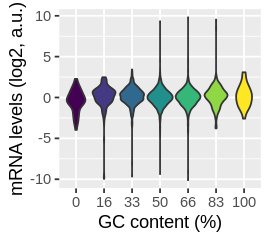

In [ ]:
options(repr.plot.width=2.25, repr.plot.height=2)

plot_data <- gc_csc %>% 
  mutate(gc = as.factor(round(gc * 100)))

plot_data %>% 
  ggplot(aes(x = gc, y = lfc, fill = gc)) +
  geom_violin() +
  scale_fill_viridis_d() +
  theme(legend.position = "none") +
  labs(x = "GC content (%)", y = "mRNA levels (log2, a.u.)")

ggsave("../figures/gc_content_violin.pdf", width = 2, height = 1.75)



## Violin plots of GC3 effect

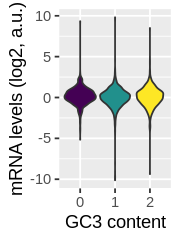

In [ ]:
options(repr.plot.width=1.5, repr.plot.height=2)

plot_data <- gc_csc %>%
  mutate(gc3 = as.factor(gc3))

plot_data %>% 
   ggplot(aes(x = gc3, y = lfc, fill = gc3)) +
   geom_violin()+
   scale_fill_viridis_d() +
   theme(legend.position = "none") +
   labs(x = "GC3 content", y = "mRNA levels (log2, a.u.)")

ggsave("../figures/gc3_content_violin.pdf", width = 1, height = 1.75)

## Calculate dipeptide effects normalized to SG-linker

- To keep lengths consistent in our Pool2 tests, we used an 8x Ser-Gly linker which had an mRNA level effect of ~lfc = 0 to pad the length of our shortened insert sequences. 

- Normalize this 8x dipeptide pool to this 8x Ser-Gly linker. SG linker sequence is "TCC-GGC"

In [ ]:
# Get SG linker lfc value
sg_value <- barcode_counts %>% 
  group_by(insert_num, sample_name) %>%
  summarize(count = sum(barcode_count), n_barcodes = dplyr::n()) %>%
  ungroup() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  filter(sample_name != 'gdna') %>%
  filter(str_detect(dicodon, "TCCGGC")) %>% 
  pivot_wider(names_from = sample_name, values_from = c("count", "n_barcodes")) %>% 
  mutate(lfc = log2(count_mrna) - log2(count_grna)) 

sg_value

# Normalize by SG linker value
sg_norm_diaa_lfc <- barcode_counts %>% 
  group_by(insert_num, sample_name) %>%
  summarize(count = sum(barcode_count), n_barcodes = dplyr::n()) %>%
  ungroup() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  filter(sample_name != 'gdna') %>% 
  group_by(diaa, aa1, aa2, sample_name) %>%
  mutate(count = sum(count), n_barcodes = sum(n_barcodes)) %>%
  ungroup() %>%
  group_by(diaa, aa1, aa2) %>%
  filter(sum(count) >= insert_reads_cutoff, sum(n_barcodes) >= n_barcodes_cutoff) %>%
  ungroup() %>% 
  pivot_wider(names_from = sample_name, values_from = c("count", "n_barcodes")) %>% 
  mutate(lfc = log2(count_mrna) - log2(count_grna)) %>%  
  group_by(diaa, aa1, aa2) %>% 
  slice(1) %>% 
  ungroup() %>% 
  mutate(lfc = lfc - sg_value$lfc) %>% 
  arrange(lfc) %>% print 

# sg_norm_diaa_counts 

`summarise()` has grouped output by 'insert_num'. You can override using the `.groups` argument.


insert_num,dicodon,diaa,codon1,codon2,aa1,aa2,count_grna,count_mrna,n_barcodes_grna,n_barcodes_mrna,lfc
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
3433,TCCGGC,SG,TCC,GGC,S,G,6496,8589,13,17,0.4029385


`summarise()` has grouped output by 'insert_num'. You can override using the `.groups` argument.


# A tibble: 441 × 12
   insert_num dicodon diaa  codon1 codon2 aa1   aa2   count_grna count_mrna
        <dbl> <chr>   <chr> <chr>  <chr>  <chr> <chr>      <dbl>      <dbl>
 1       2608 GGATAA  G*    GGA    TAA    G     *         178222      22193
 2       3136 TACAAA  YK    TAC    AAA    Y     K          96768      15509
 3        529 AGACAC  RH    AGA    CAC    R     H         125059      20163
 4        304 ACATAA  T*    ACA    TAA    T     *         309339      59506
 5       1096 CACAGA  HR    CAC    AGA    H     R         159427      31199
 6        560 AGATAA  R*    AGA    TAA    R     *         234307      48011
 7        780 ATAATA  II    ATA    ATA    I     I         197432      40966
 8       2816 GTAAAA  VK    GTA    AAA    V     K         106782      22871
 9         44 AAAGTA  KV    AAA    GTA    K     V         169872      36908
10         12 AAAATA  KI    AAA    ATA    K     I          71876      16166
# … with 431 more rows, and 3 more variables: n_barcodes_grna <int>

## Replot AA heatmap with values normalized to SG linker

- Obviously this doesn't change anything. It just pushes values all down by -0.4 lfc, since that was the value of the TCCGGC Ser-Gly linker. 

- In this case, it makes no sense to normalize to the linker because we just want to plot things relative to each other. 

- Also, it just looks a litte weird, because the link itself has a slight positive effect on mRNA level; this makes all inserts look relatively more destabilizing. Of note, the average effect of Ser-Gly across all codon contexts is about -0.2 lfc (so very little effect). 

- Honestly, maybe we _should_ just normalize the pool2 data to RH8's effect in the 8x library. It might be easier than dealing with this linker buisness. 

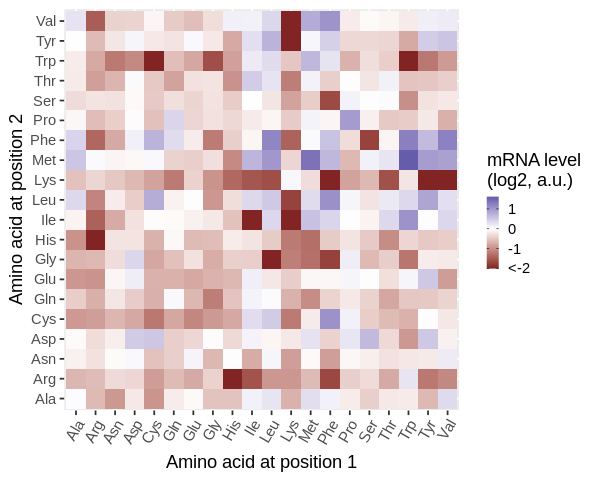

In [ ]:
options(repr.plot.width=5, repr.plot.height=4) # For ipynb visualization

AMINO_ACID_CODE = c(AMINO_ACID_CODE, c("*" = "Stop"))

sg_norm_diaa_lfc %>% 
  mutate(aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
  complete(aa1, aa2) %>% 
  filter(aa1 != "*", aa2 != "*") %>% 
  mutate(lfc = case_when(
    lfc < -2 ~ -2,
    lfc > 2  ~ 2,
    T ~ lfc)) %>%
  mutate(aa1 = AMINO_ACID_CODE[aa1], aa2 = AMINO_ACID_CODE[aa2]) %>% 
  # mutate(aa2 = fct_rev(aa2)) %>%
  # mutate(aa1 = fct_relevel(aa1, "Stop", after = 20)) %>% 
  # mutate(aa2 = fct_relevel(aa2, "Stop", after = 20)) %>% 
  ggplot(aes(x = aa1, y = aa2, fill = lfc)) +
  geom_tile() +
  scale_fill_gradient2(labels = c("<-2", -1, 0, 1, ">2"),
                       guide = guide_colorbar(barwidth = 0.5, barheight = 3, ticks.colour = "black"), na.value = "grey50") +
  # scale_fill_viridis_c() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1),
        axis.title.x = element_text(margin = margin(t = 4)),
        axis.line = element_blank()
        ) +
  labs(fill = "mRNA level\n(log2, a.u.)", x = "Amino acid at position 1", y = "Amino acid at position 2")